In [1]:
import numpy as np
import oracles
import optimization
import matplotlib.pyplot as plt

from scipy.sparse import diags

# Эксперимент 1: Зависимость числа итераций метода сопряженных градиентов от числа обусловленности и размерности пространства

Сгенерируем несколько выборок и проверим зависимость числа итераций conjugate_gradients от числа обусловленности и размерности пространства.

In [2]:
np.random.seed(1488)

In [3]:
def create_graph(dim_and_color, n_repetitions=2, max_weight=250):
    for dim, color in dim_and_color:
        for repetition in range(n_repetitions):
            iterations = []
            for i in range(1, max_weight):
                A = diags(np.random.randint(i, size=dim) + 1).toarray()
                b = np.random.randint(i, size=dim)
                solution_time = optimization.conjugate_gradients(lambda x: A @ x, b, np.zeros(dim), trace=True)[2]['time']
                iterations.append(len(solution_time))
            label = "Размерность " + str(dim) + ", №" + str(repetition + 1)
            x = np.arange(1, len(iterations) + 1)
            y = iterations
            plt.plot(x, y, label=label, color=color)
    plt.title("Зависимость числа итераций от числа обусловленности и размерности")
    plt.xlabel("Минимальный вес в системе Ax = b")
    plt.ylabel("Число итераций поиска решения")
    plt.legend()

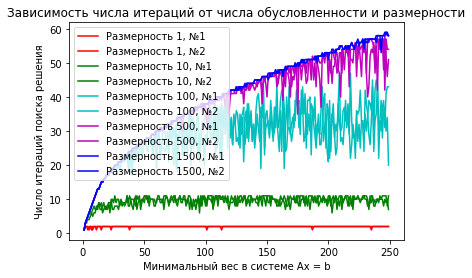

In [4]:
create_graph([(1, 'r'), (10, 'g'), (100, 'c'), (500, 'm'), (1500, 'b')], 2, 250)

Из графика видно, что число итераций для сходимости увеличивается как с ростом размерности, так и с ростом числа обусловленности. В какой-то момент число итераций в среднем выходит на плато - скорее всего, этот момент наступает, когда число обусловленности сравнивается с размерностью задачи.

# Эксперимент 2: Выбор размера истории в методе LBFGS

In [5]:
from sklearn.datasets import load_svmlight_file
from oracles import create_log_reg_oracle

Загрузим данные и построим графики зависимости времени работы и числа итераций сходимости от размера хранимой истории в методе LBFGS.

In [6]:
# https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary.html#gisette
X, y = load_svmlight_file("gisette_scale.bz2")[:2]

In [7]:
def create_graph(sizes, graph_type):
    oracle = create_log_reg_oracle(X, y, 1 / X.shape[0])
    for size in sizes:
        _, _, history = optimization.lbfgs(oracle, np.zeros(X.shape[1]), 
                                           memory_size=size, line_search_options={'method': 'Wolfe'}, trace=True)
        
        grad_norm = history['grad_norm'][0] ** 2
        if graph_type == 'time':
            xs = history['time']
            plt.xlabel("Время работы")
            
        elif graph_type == 'iterations':
            xs = np.arange(len(history['grad_norm']))
            plt.xlabel("Число итераций")
            
        ys = np.array(history['grad_norm']) ** 2 / grad_norm
        plt.plot(xs, ys, label="Размер истории " + str(size))
    
    plt.title("Зависимость от размера хранимой истории в методе LBFGS")
    plt.ylabel("Отн. квадрат нормы градиента")
    plt.yscale('log')
    plt.legend()
    plt.show()

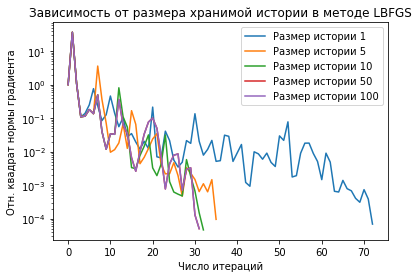

In [8]:
create_graph([1, 5, 10, 50, 100], 'iterations')

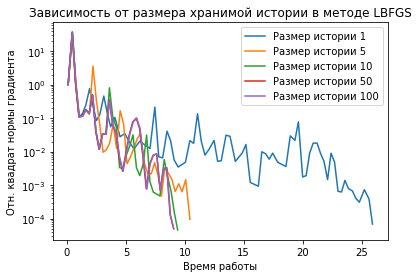

In [9]:
create_graph([1, 5, 10, 50, 100], 'time')

Из графиков видно, что с ростом размера хранимой истории число итераций и реальное время работы снижаются. Графики для размера истории 50 и 100 практически идентичны. Можно предположить, что делать размер истории больше 5-10 нецелесообразно, так как выигрыш по времени практически не достигается.

# Эксперимент 3: Сравнение методов на реальной задаче логистической регрессии

Сравним усеченный метод Ньютона, метод L-BFGS и градиентный спуск на задаче gisette.

In [10]:
from gradient_descent import gradient_descent

In [11]:
def create_graph(title):
    X, y = load_svmlight_file("gisette_scale.bz2")[:2]
    oracle = oracles.create_log_reg_oracle(X, y, 1 / X.shape[0])
    _, _, history_lbfgs = optimization.lbfgs(oracle, np.zeros(X.shape[1]), trace=True)
    _, _, history_newton = optimization.hessian_free_newton(oracle, np.zeros(X.shape[1]), trace=True)
    # Исключён из-за слишком долгой сходимости
    # _, _, history_gradient = gradient_descent(oracle, np.zeros(X.shape[1]), trace=True, tolerance=1e-4)
    dataset = [(history_lbfgs, "lbfgs"), (history_newton, "hess-free newton")]
    
    for history, label in dataset:
        if title == "Зависимость значения функции против номера итерации метода":
            xs = np.arange(len(history['func']))
            ys = np.array(np.abs(np.array(history['func']) - np.min(history['func'])))
            plt.plot(xs, ys, label=label)
            plt.xlabel("Число итераций")
            plt.ylabel("Значения функции")
        elif title == "Зависимость значения функции против реального времени работы":
            xs = history['time']
            ys = np.array(np.abs(np.array(history['func']) - np.min(history['func'])))
            plt.plot(xs, ys, label=label)
            plt.xlabel("Время работы")
            plt.ylabel("Значения функции")
        elif title == "Зависимость отн. квадрата нормы градиента против реального времени работы":
            xs = history['time']
            ys = np.array(history['func']) ** 2 / history['func'][0] ** 2
            plt.plot(xs, ys, label=label)
            plt.xlabel("Время работы")
            plt.ylabel("Отн. квадрат нормы градиента")
            plt.yscale('log')
    plt.title(title)
    plt.legend()

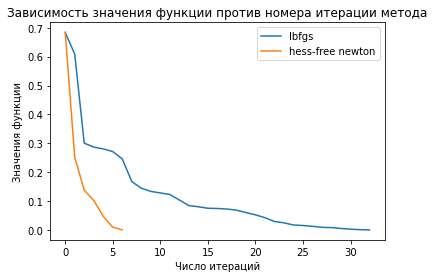

In [12]:
create_graph("Зависимость значения функции против номера итерации метода")

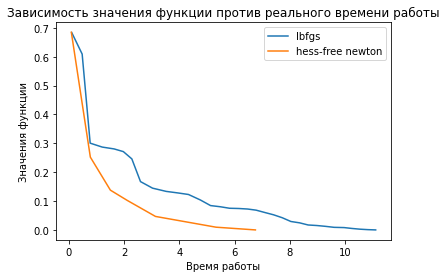

In [13]:
create_graph("Зависимость значения функции против реального времени работы")

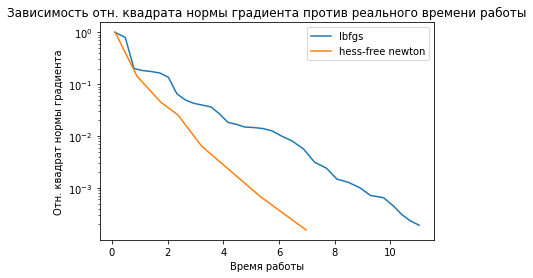

In [14]:
create_graph("Зависимость отн. квадрата нормы градиента против реального времени работы")

Из графиков видно, что усечённый метод Ньютона оказался быстрее по времени и числу итераций, чем LBFGS. Градиентный спуск сходится в разы дольше.